In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline
%load_ext ipycache

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 300
import numpy as np
import scipy
import sklearn as sk
import xgboost as xgb

from eli5 import show_weights

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt

/Users/evgeny/Library/Python/2.7/lib/python/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/evgeny/Library/Python/2.7/lib/python/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/evgeny/Library/Python/2.7/lib/python/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import math

#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [
        (math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 
        for i,pred in enumerate(y_pred)
    ]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

def rmse(y, y_pred):
    return np.sqrt(((y_pred - y) ** 2).mean())

# Препроцессинг фич

In [3]:
# train_raw = pd.read_csv("data/train.csv")
train_raw = pd.read_csv("data/train_without_noise.csv")
test = pd.read_csv("data/test.csv")
macro = pd.read_csv("data/macro.csv")
train_raw.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [4]:
def preprocess_anomaly(df):
    df["full_sq"] = map(lambda x: x if x > 10 else float("NaN"), df["full_sq"])
    df["life_sq"] = map(lambda x: x if x > 5 else float("NaN"), df["life_sq"])
    df["kitch_sq"] = map(lambda x: x if x > 2 else float("NaN"), df["kitch_sq"])
    
    # superclean
    # https://www.kaggle.com/keremt/very-extensive-cleaning-by-sberbank-discussions
    df.ix[df[df.life_sq > df.full_sq].index, "life_sq"] = np.NaN
    df.ix[df[df.kitch_sq >= df.life_sq].index, "kitch_sq"] = np.NaN

    df.ix[df[df.kitch_sq == 0].index, "kitch_sq"] = np.NaN
    df.ix[df[df.kitch_sq == 1].index, "kitch_sq"] = np.NaN

    df.ix[df[df.num_room == 0].index, "num_room"] = np.NaN
    
    df.ix[df[df.floor == 0].index, "floor"] = np.NaN
    df.ix[df[df.max_floor == 0].index, "max_floor"] = np.NaN
    
    df.ix[df[df.floor > df.max_floor].index, "max_floor"] = np.NaN
    
    df.ix[df[df.state == 33].index, "state"] = np.NaN
    
    df.ix[df[df.build_year == 20052009].index, "build_year"] = 2005
    df.ix[df[df.build_year == 20].index, "build_year"] = 2000
    df.ix[df[df.build_year == 215].index, "build_year"] = 2015

    df.ix[df[df.build_year < 1500].index, "build_year"] = np.NaN
    df.ix[df[df.build_year > 2022].index, "build_year"] = np.NaN

    return df

In [5]:
def preprocess_categorial(df):

    for c in list(df.columns):
        if df[c].dtype == 'object':
            lbl = sk.preprocessing.LabelEncoder()
            try:
                lbl.fit(list(train_raw[c].values) + list(test[c].values)) 
            except KeyError:
                lbl.fit(df[c].values) 
            df[c + "_le"] = lbl.transform(list(df[c].values))

#     df = mess_y_categorial(df, 5)

    df = df.select_dtypes(exclude=['object'])
    return df

def apply_categorial(test, train):
    for c in list(test.columns):
        if test[c].dtype == 'object':
            lbl = sk.preprocessing.LabelEncoder()
            try:
                lbl.fit(list(train_raw[c].values) + list(test[c].values)) 
            except KeyError:
                lbl.fit(test[c].values) 
            test[c + "_le"] = lbl.transform(list(test[c].values))

#     test = mess_y_categorial_fold(test, train)

    test = test.select_dtypes(exclude=['object'])
    return test


def smoothed_likelihood(targ_mean, nrows, globalmean, alpha=10):
    try:
        return (targ_mean * nrows + globalmean * alpha) / (nrows + alpha)
    except Exception:
        return float("NaN")


def mess_y_categorial(df, nfolds=3, alpha=10):
    from copy import copy

    folds = np.array_split(df, nfolds)
    newfolds = []
    for i in range(nfolds):
        fold = folds[i]

        other_folds = copy(folds)
        other_folds.pop(i)
        other_fold = pd.concat(other_folds)

        newfolds.append(mess_y_categorial_fold(fold, other_fold, alpha=10))

    return pd.concat(newfolds)

def mess_y_categorial_fold(fold_raw, other_fold, cols=None, y_col="price_doc", alpha=10):
    fold = fold_raw.copy()
    if not cols:
        cols = list(fold.select_dtypes(include=["object"]).columns)
    globalmean = other_fold[y_col].mean()
    for c in cols:

        target_mean = other_fold[[c, y_col]].groupby(c).mean().to_dict()[y_col]
        nrows = other_fold[c].value_counts().to_dict()

        fold[c + "_sll"] = fold[c].apply(
            lambda x: smoothed_likelihood(target_mean.get(x), nrows.get(x), globalmean, alpha) if x else float("NaN")
        )
    return fold

def feature_exclude(df):
    feats = []

    with open("greedy_search.tsv") as gs:
        for line in gs:
            row = line.strip().split("\t")
            if len(row) < 6:
                continue
            if row[5] == "remove":
                feats.append(row[0])
    if feats:
        df = df.drop(feats, axis=1)
    return df

In [6]:
def apply_macro(df):
    macro_cols = [
        'timestamp', "balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
        "micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
        "income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"
    ]
    return pd.merge(df, macro, on='timestamp', how='left')

In [7]:
def preprocess(df):
    from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
    
#     df = apply_macro(df)

    ecology = ["no data", "poor", "satisfactory", "good", "excellent"]
    df["ecology_index"] = map(ecology.index, df["ecology"].values)

    df["age_of_building"] = df["timestamp"].apply(lambda x: x.split("-")[0]).astype(int) - df["build_year"]
    df["is_build_in_progress"] = df["age_of_building"].apply(lambda x: "yes" if x < 0 else "no")

    bool_feats = [
        "thermal_power_plant_raion",
        "incineration_raion",
        "oil_chemistry_raion",
        "radiation_raion",
        "railroad_terminal_raion",
        "big_market_raion",
        "nuclear_reactor_raion",
        "detention_facility_raion",
        "water_1line",
        "big_road1_1line",
        "railroad_1line",
        "culture_objects_top_25"
    ]
    for bf in bool_feats:
        df[bf + "_bool"] = map(lambda x: x == "yes", df[bf].values)

    df = preprocess_anomaly(df)

    df['rel_floor'] = df['floor'] / df['max_floor'].astype(float)
    df['rel_kitch_sq'] = df['kitch_sq'] / df['full_sq'].astype(float)
    df['rel_life_sq'] = df['life_sq'] / df['full_sq'].astype(float)

    df["material_cat"] = df.material.fillna(0).astype(int).astype(str).replace("0", "")
    df["state_cat"] = df.state.fillna(0).astype(int).astype(str).replace("0", "")
    df["num_room_cat"] = df.num_room.fillna(0).astype(int).astype(str).replace("0", "")
    df["build_year_cat"] = df.build_year.fillna(0).astype(int).astype(str).replace("0", "")

    df["ID_metro"] = df.ID_metro.fillna(-10).astype(int).astype(str).replace("-10", "")
    df["ID_railroad_station_walk"] = df.ID_railroad_station_walk.replace("", "-10").fillna(-10).astype(int).astype(str).replace("-10", "")
    df["ID_railroad_station_avto"] = df.ID_railroad_station_avto.fillna(-10).astype(int).astype(str).replace("-10", "")
    df["ID_big_road1"] = df.ID_big_road1.fillna(-10).astype(int).astype(str).replace("-10", "")
    df["ID_big_road2"] = df.ID_big_road2.fillna(-10).astype(int).astype(str).replace("-10", "")
    df["ID_bus_terminal"] = df.ID_bus_terminal.fillna(-10).astype(int).astype(str).replace("-10", "")

#    # ratio of living area to full area #
#     df["ratio_life_sq_full_sq"] = df["life_sq"] / np.maximum(df["full_sq"].astype("float"),1)
#     df["ratio_life_sq_full_sq"].ix[df["ratio_life_sq_full_sq"]<0] = 0
#     df["ratio_life_sq_full_sq"].ix[df["ratio_life_sq_full_sq"]>1] = 1

#     # ratio of kitchen area to living area #
#     df["ratio_kitch_sq_life_sq"] = df["kitch_sq"] / np.maximum(df["life_sq"].astype("float"),1)
#     df["ratio_kitch_sq_life_sq"].ix[df["ratio_kitch_sq_life_sq"]<0] = 0
#     df["ratio_kitch_sq_life_sq"].ix[df["ratio_kitch_sq_life_sq"]>1] = 1

#     # ratio of kitchen area to full area #
#     df["ratio_kitch_sq_full_sq"] = df["kitch_sq"] / np.maximum(df["full_sq"].astype("float"),1)
#     df["ratio_kitch_sq_full_sq"].ix[df["ratio_kitch_sq_full_sq"]<0] = 0
#     df["ratio_kitch_sq_full_sq"].ix[df["ratio_kitch_sq_full_sq"]>1] = 1

    df = df.drop(["id", "timestamp"], axis=1)

    return df

In [8]:
train_pr = preprocess(train_raw)
train_pr = preprocess_categorial(train_pr)
train = feature_exclude(train_pr)
train["price_meter"] = train["price_doc"] / train["full_sq"]
# train = train.fillna(-1)

X = train.drop(["price_doc", "price_meter"], axis=1)
y = train["price_meter"].values

# Обучение моделей

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X.values, y, test_size=0.20, random_state=43)

dtrain_all = xgb.DMatrix(X.values, y, feature_names=X.columns)
dtrain = xgb.DMatrix(X_train, y_train, feature_names=X.columns)
dval = xgb.DMatrix(X_val, y_val, feature_names=X.columns)

In [11]:
xgb_params = {
    'max_depth': 5,
    'n_estimators': 200,
    'learning_rate': 0.01,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

# Uncomment to tune XGB `num_boost_rounds`
model = xgb.train(xgb_params, dtrain, num_boost_round=4000, evals=[(dval, 'val')],
                  early_stopping_rounds=40, verbose_eval=40)

num_boost_round = model.best_iteration

[0]	val-rmse:8.28101e+06
Will train until val-rmse hasn't improved in 40 rounds.
[40]	val-rmse:5.9641e+06
[80]	val-rmse:4.52109e+06
[120]	val-rmse:3.67296e+06
[160]	val-rmse:3.19137e+06
[200]	val-rmse:2.93826e+06
[240]	val-rmse:2.80753e+06
[280]	val-rmse:2.73126e+06
[320]	val-rmse:2.69304e+06
[360]	val-rmse:2.66852e+06
[400]	val-rmse:2.65234e+06
[440]	val-rmse:2.64059e+06
[480]	val-rmse:2.62986e+06
[520]	val-rmse:2.62135e+06
[560]	val-rmse:2.615e+06
[600]	val-rmse:2.61025e+06
[640]	val-rmse:2.60486e+06
[680]	val-rmse:2.6013e+06
[720]	val-rmse:2.5986e+06
[760]	val-rmse:2.59474e+06
[800]	val-rmse:2.59211e+06
[840]	val-rmse:2.58855e+06
[880]	val-rmse:2.58689e+06
[920]	val-rmse:2.58484e+06
[960]	val-rmse:2.5832e+06
[1000]	val-rmse:2.58156e+06
[1040]	val-rmse:2.58041e+06
[1080]	val-rmse:2.57886e+06
[1120]	val-rmse:2.57719e+06
[1160]	val-rmse:2.57494e+06
[1200]	val-rmse:2.57372e+06
[1240]	val-rmse:2.5726e+06
[1280]	val-rmse:2.57168e+06
[1320]	val-rmse:2.57047e+06
[1360]	val-rmse:2.57015e+06


In [12]:
imp_features = pd.DataFrame(
    model.get_fscore().items(), 
    columns=['feature','importance']
).sort_values('importance', ascending=False)
imp_features

,feature,importance
88,full_sq,7121
161,life_sq,2326
201,floor,2085
17,max_floor,1354
158,build_year,1343
31,rel_life_sq,1186
9,rel_kitch_sq,1064
202,rel_floor,879
76,kitch_sq,732
89,state,687


[0]	train-rmse:8.41649e+06+41741.5	test-rmse:8.41749e+06+84540.3
[40]	train-rmse:6.03322e+06+28199.8	test-rmse:6.0902e+06+71143.3
[80]	train-rmse:4.52591e+06+24294.8	test-rmse:4.65295e+06+63603
[120]	train-rmse:3.59694e+06+24673.6	test-rmse:3.799e+06+61408.8
[160]	train-rmse:3.03773e+06+23604.7	test-rmse:3.31908e+06+62720.6
[200]	train-rmse:2.70512e+06+20565.3	test-rmse:3.05728e+06+62195
[240]	train-rmse:2.50918e+06+21138.6	test-rmse:2.91332e+06+61563.8
[280]	train-rmse:2.3916e+06+20671.9	test-rmse:2.83512e+06+61156.3
[320]	train-rmse:2.3135e+06+20144.3	test-rmse:2.79042e+06+59205.5
[360]	train-rmse:2.25861e+06+19201.1	test-rmse:2.7633e+06+58681.9
[400]	train-rmse:2.21503e+06+19435.8	test-rmse:2.74456e+06+57977.8
[440]	train-rmse:2.18046e+06+19601.1	test-rmse:2.73086e+06+57811.9
[480]	train-rmse:2.15196e+06+19933	test-rmse:2.72007e+06+58000.3
[520]	train-rmse:2.12786e+06+19380.8	test-rmse:2.71168e+06+57381.1
[560]	train-rmse:2.10665e+06+19583.9	test-rmse:2.70399e+06+57641.7
[600]	train

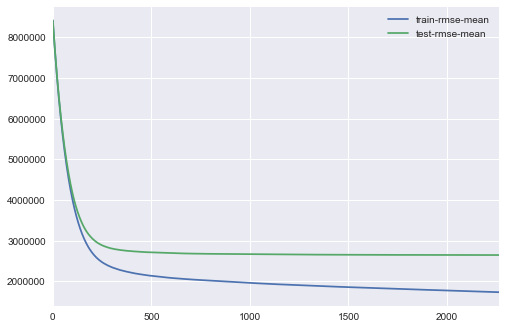

In [13]:
cv_output = xgb.cv(dict(xgb_params, silent=0), dtrain_all, num_boost_round=num_boost_round, verbose_eval=40)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [14]:
model = xgb.train(dict(xgb_params, silent=0), dtrain_all, num_boost_round=num_boost_round, verbose_eval=40)
print "predict-train:", rmse(model.predict(dtrain_all), y)

predict-train: 1881896.66663


# Submission

In [15]:
test_pr = preprocess(test)
train_pr = preprocess(train_raw)
test_pr = apply_categorial(test_pr, train_pr)
test_pr = feature_exclude(test_pr)
# test_pr = test_pr.fillna(-1)c

dtest = xgb.DMatrix(test_pr.values, feature_names=test_pr.columns)
y_pred = model.predict(dtest)

# y_pred = model.predict(test_pr.values)

# y_pred = np.exp(y_pred) - 1

submdf = pd.DataFrame({"id": test["id"], "price_doc": y_pred})
submdf.to_csv("data/submission.csv", header=True, index=False)
!head data/submission.csv

id,price_doc
30474,5568339.0
30475,8274571.5
30476,5637723.5
30477,5850102.5
30478,5368623.0
30479,8247314.5
30480,4413024.0
30481,3841126.5
30482,4725561.5


5*200, no macro, add rel features, no log price, train_without_noise, 
4000 iter, not fillna, superclean, ID metro + other, no ratio feats, no superfeatures, Label Encoding,
is_build_in_progress + age_of_building, kfold wo shuffle, feature_exclude:
    
    val-rmse:2.55793e+06
    train-rmse:1.74066e+06+28727.3	test-rmse:2.65025e+06+64969.5
    predict-train: 1881896.66663
    kaggle: 0.31344

5*200, no macro, add rel features, no log price, train_without_noise, 
4000 iter, not fillna, superclean, ID metro + other, no ratio feats, no superfeatures, Label Encoding,
is_build_in_progress + age_of_building, kfold wo shuffle, feature_exclude 143:
    
    val-rmse:2.54654e+06
    train-rmse:1.74594e+06+24020	test-rmse:2.66053e+06+67300.3
    predict-train: 1883352.60935
    kaggle: 0.31364
    
5*200, no macro, add rel features, no log price, train_without_noise, 
4000 iter, not fillna, superclean, ID metro, no ratio feats, no superfeatures, Label Encoding,
is_build_in_progress + age_of_building, kfold wo shuffle, feature_exclude 143:

    val-rmse:2.55613e+06
    train-rmse:1.74466e+06+27385.6	test-rmse:2.66422e+06+69734.1
    predict-train: 1888051.35357
    kaggle: 0.31366
    

5*200, no macro, add rel features, no log price, train_without_noise, 
4000 iter, not fillna, superclean, ID metro with other ID, ratio feats, no superfeatures, Label Encoding,
is_build_in_progress + age_of_building, kfold wo shuffle, feature_exclude 143:
    
    val-rmse:2.58557e+06
    train-rmse:1.98509e+06+26803.7	test-rmse:2.68755e+06+59691.1
    predict-train: 2092731.29028
    kaggle: 0.31731

###################################################


5*200, no macro, add rel features, no log price, train_without_noise:
    
    val-rmse:2.63772e+06
    train-rmse:1.9989e+06+10986.4	test-rmse:2.69158e+06+53020
    predict-train: 2076010.27131
    kaggle: 0.31720

5*200, no macro, add rel features, no log price, train_with_noise:

    val-rmse:2.53378e+06
    train-rmse:1.95069e+06+16166.4	test-rmse:2.69703e+06+61455.1
    predict-train: 2054421.59869
    kaggle: 0.32056

5*200, macro, add rel features, no log price, train_without_noise:
    
    val-rmse:2.79632e+06
    train-rmse:1.81015e+06+19781.2	test-rmse:2.6641e+06+123875
    predict-train: 1904063.27368
    kaggle: 0.32976

5*200, no macro, add rel features, no log price, train_without_noise:
    
    val-rmse:2.61682e+06
    train-rmse:1.81123e+06+27681.2	test-rmse:2.66923e+06+53925.7
    predict-train: 1899129.43771
    kaggle: 0.31592

5*200, no macro, add rel features, no log price, train_without_noise, 4000 iter:

    val-rmse:2.61055e+06
    train-rmse:1.71826e+06+30076.1	test-rmse:2.66515e+06+54583.5
    predict-train: 1814572.97424
    kaggle: 0.31602

7*300, no macro, add rel features, no log price, train_without_noise, 4000 iter:

    val-rmse:2.59955e+06
    train-rmse:1.41393e+06+21208.1	test-rmse:2.6763e+06+35553.3
    predict-train: 1548257.49121
    kaggle: 0.31768

4*300, no macro, add rel features, no log price, train_without_noise, 4000 iter:
    
    val-rmse:2.63407e+06
    train-rmse:1.96513e+06+21470.8	test-rmse:2.69417e+06+74288.3
    predict-train: 2062299.41091
    kaggle: 0.31952

7*200, no macro, add rel features, no log price, train_without_noise, 4000 iter:

    val-rmse:2.59955e+06
    train-rmse:1.41393e+06+21208.1	test-rmse:2.6763e+06+35553.3
    predict-train: 1548257.49121

5*300, no macro, add rel features, no log price, train_without_noise, 4000 iter:
    
    val-rmse:2.61055e+06
    train-rmse:1.71826e+06+30076.1	test-rmse:2.66515e+06+54583.5
    predict-train: 1814572.97424

5*200, no macro, add rel features, no log price, train_without_noise, 4000 iter, not fillna:

    val-rmse:2.61664e+06
    train-rmse:1.77892e+06+23111	test-rmse:2.65829e+06+56398.6
    predict-train: 1875799.54634
    kaggle: 0.31521

5*200, no macro, add rel features, no log price, train_without_noise, 4000 iter, not fillna, superclean:
    
    val-rmse:2.6265e+06
    train-rmse:1.78478e+06+22545.4	test-rmse:2.66179e+06+60626.3
    predict-train: 1881672.27588
    kaggle: 0.31476

5*200, no macro, add rel features, no log price, train_without_noise, 4000 iter, not fillna, superclean, no super features + Label Encoding:
    
    val-rmse:2.56494e+06
    train-rmse:1.78862e+06+18589.1	test-rmse:2.69283e+06+79861.4
    predict-train: 1923466.41923
    kaggle: 0.31434

5*200, no macro, add rel features, no log price, train_without_noise, 4000 iter, not fillna, superclean, remove material state num_room:
    
    val-rmse:2.56932e+06
    train-rmse:1.88495e+06+20133.7	test-rmse:2.69624e+06+70491.2
    predict-train: 1979198.19201
    kaggle: 0.31513

5*200, no macro, add rel features, no log price, train_without_noise, 4000 iter, not fillna, superclean, ID metro/bus...:
    
    val-rmse:2.60017e+06
    train-rmse:1.80654e+06+19453.5	test-rmse:2.68203e+06+68169.5
    predict-train: 1906439.98603
    kaggle: 0.31927

5*200, no macro, add rel features, no log price, train_without_noise, 4000 iter, not fillna, superclean, ID metro, remove 50 features:
    
    val-rmse:2.93665e+06
    train-rmse:1.73425e+06+19462.4	test-rmse:2.68682e+06+140661
    predict-train: 1861268.6455
    kaggle: 0.31555

5*200, no macro, add rel features, no log price, train_without_noise, 
4000 iter, not fillna, superclean, ID metro, remove 50 features, add ratio feats:

    val-rmse:2.59747e+06
    train-rmse:1.75828e+06+26639.4	test-rmse:2.68491e+06+67201.8
    predict-train: 1875707.6581
    kaggle: 0.31760

5*200, no macro, add rel features, no log price, train_without_noise, 
4000 iter, not fillna, superclean, ID metro, no ratio feats, superfeatures + Label Encoding,
is_build_in_progress + age_of_building, kfold wo shuffle:
    
    val-rmse:2.5419e+06
    train-rmse:1.74381e+06+22710.7	test-rmse:2.65787e+06+66889.9
    predict-train: 1862467.67153
    kaggle: 0.31716

5*200, no macro, add rel features, no log price, train_without_noise, 
4000 iter, not fillna, superclean, ID metro, no ratio feats, no superfeatures, Label Encoding,
is_build_in_progress + age_of_building, kfold wo shuffle:
    
    val-rmse:2.5676e+06
    train-rmse:1.81485e+06+24274	test-rmse:2.67324e+06+60153.1
    predict-train: 1947645.83102
    kaggle: 0.31376

# Feature Greedy selection

In [45]:
from tqdm import tqdm
def get_best_score(train):
    xgb_params = {
        'max_depth': 5,
        'n_estimators': 200,
        'learning_rate': 0.01,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'silent': 1
    }
    cvres = xgb.cv(xgb_params, train, num_boost_round=4000, early_stopping_rounds=40)
    return cvres["test-rmse-mean"].min(), cvres["test-rmse-mean"].argmin()

def df2DMatrix(df):
    return xgb.DMatrix(data=df.drop("price_doc", axis=1).values, label=df["price_doc"].values)

def greedy_remove_features(df, feature_importances):
    train = df
    with open("greedy_search.tsv", "a") as f:
        best_score, iterno = get_best_score(df2DMatrix(df))
        f.write("\t".join(["INITIAL", str(best_score), str(iterno)]) + "\n")
        to_analyze = sorted(feature_importances.items(), key=lambda x: x[1])
        for feat, feat_importance in tqdm(to_analyze):
            f.flush()
            candidate_train = train.drop(feat, axis=1)
            cand_best_score, iterno = get_best_score(df2DMatrix(candidate_train))

            if cand_best_score > best_score:
                # стало хуже, оставляем фичу
                f.write("\t".join([feat, str(cand_best_score), str(best_score), str(feat_importance), str(iterno), "skip"]) + "\n")
                f.flush()
                continue

            f.write("\t".join([feat, str(cand_best_score), str(best_score), str(feat_importance), str(iterno), "remove"]) + "\n")
            best_score = cand_best_score
            train = candidate_train


In [47]:
feature_importances = imp_features.set_index("feature").to_dict()["importance"]

train_gs = train
with open("greedy_search.tsv") as gs:
    for line in gs:
        row = line.strip().split("\t")
        if len(row) < 6:
            continue
        if row[5] == "remove":
            try:
                train_gs = train_gs.drop(row[0], axis=1)
            except ValueError:
                pass
            print "drop", row[0]
        feature_importances.pop(row[0], None)

greedy_remove_features(train_gs, feature_importances)

drop 0_6_female
drop young_female
drop market_count_500
drop cafe_count_500_price_4000
drop nuclear_reactor_raion_bool
drop work_male
drop radiation_raion_bool
drop 0_13_female
drop detention_facility_raion_bool
drop thermal_power_plant_raion_bool
drop work_female
drop ecology_index
drop 0_17_male
drop railroad_terminal_raion_bool
drop church_count_1500
drop big_road1_1line_bool
drop additional_education_raion
drop cafe_count_1000_price_4000
drop cafe_count_3000_price_1500
drop office_count_5000
drop children_school
drop cafe_avg_price_5000
drop build_count_1946-1970
drop school_education_centers_raion
drop build_count_foam
drop market_count_5000
drop cafe_count_3000_price_1000
drop cafe_sum_5000_max_price_avg
drop cafe_count_500_price_2500
drop cafe_count_500_price_1500


100%|██████████| 123/123 [20:40:45<00:00, 613.14s/it]  
